# Fake News Exploratory Data Analysis

Get subset of FakeNewCorpus data set.

In [23]:
import pandas as pd
import regex as re

# Import 250 articles as pandas df
raw_data = pd.read_csv('https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv', dtype={"content": "string"}, index_col=0) 
raw_data.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


### Cleaning and preprocessing

Perform basic cleaning: remove urls, dates, numbers, emails.

In [24]:
data250 = raw_data.copy(deep = True) #

In [25]:
mail_pattern = re.compile(r"(?P<Mails>[\w\.-]+@[\w\.-]+\.[\w]+)")
url_pattern = re.compile(r"(?P<URL>(?:(?:https?|ftp):[/][/])?[\w/\-?=%.]+\.[\w/\-&?=%.]+)")
date_pattern = re.compile(r"([\d]{1,2}[\/|\-][\d]{1,2}(?:[\/|\-][\d]{2,4})?|[\d]{2,4}[\/|\-][\d]{1,2}[\/|\-][\d]{1,2}|(?:january|february|march|april|may|june|july|august|september|october|november|december)[\s][\d]{1,2}[a-z][a-z](?:\s[\d]{2,4})|[\d][\d]\w?\w?\sof\s(?:january|february|march|april|may|june|july|august|september|october|november|december)(?:\s[\d]{2,4})?|(?:january|february|march|april|may|june|july|august|september|october|november|december)\s\d\d?\w?\w?,?(?:\s\d{2,4})?)")
num_pattern = re.compile(r"\w*\d+\w*")
punct_remove = re.compile(r"[^\w\s]+")
white_space = re.compile(r"[\s]+|\n+")

def clean_string(st):
    s1 = st.lower()
    s2 = mail_pattern.sub("mail", s1)
    s3 = url_pattern.sub("url", s2)
    s4 = date_pattern.sub("date", s3)
    s5 = num_pattern.sub("num", s4)
    s6 = punct_remove.sub(" ", s5)
    s7 = white_space.sub(" ", s6)
    return s7

def clean_dataframe(dataframe):
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(clean_string)
    end = time.time()
    print("cleaning took " + str(end - start) + " seconds")

In [26]:
clean_dataframe(data250)
data250['content'].head()

cleaning took 0.6668977737426758 seconds


0    sometimes the power of christmas will make you...
1    awakening of num strands of dna reconnecting w...
2    never hike alone a friday the num fan film usa...
3    when a rare shark was caught scientists were l...
4    donald trump has the unnerving ability to abil...
Name: content, dtype: object

Tokenize the text
Remove stopwords and compute reduction of vocabulary rate after having removed them
Stem words and compute reduction rate of vocabulary

In [27]:
def remove_english_stopwords(stopwords):
    def remove_stopwords(tokenlist):
        return filter(lambda x : x not in stopwords, tokenlist)
    return remove_stopwords

def stem_tokens():
    stemmer = PorterStemmer()
    def stem_tokenlist(tokenlist):
        return map(stemmer.stem, tokenlist)
    return stem_tokenlist

def tokenize():
    def tokenize_text(s):
        return list((map(nltk.word_tokenize, s)))
    return tokenize_text

def to_list():
    def turn_to_list(it):
        return list(it)
    return turn_to_list

def preprocess(dataframe):
    
    # tokenize content column
    #print("Tokenizing...")
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(nltk.word_tokenize)
    end = time.time()
    print("tokenizing took " + str(end - start) + " seconds")
    #tokens = list(itertools.chain.from_iterable(dataframe['content']))
    #vocabulary = set(tokens)
    # remove stopwords
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(remove_english_stopwords(stopwords.words('english')))
    end = time.time()
    print("removing stopwords took " + str(end - start) + " seconds")
    #tokens_no_stopwords = list(itertools.chain.from_iterable(dataframe['content']))
    #vocabulary_no_stopwords = set(tokens_no_stopwords)
    #print("Reduction rate of removing stopwords: " + str(1 - len(vocabulary_no_stopwords) / len(vocabulary)))
    # stem tokens
    start = time.time()
    dataframe['content'] = dataframe['content'].apply(stem_tokens())
    end = time.time()
    print("stemming took " + str(end - start) + " seconds")

    start = time.time()
    dataframe['content'] = dataframe['content'].apply(to_list())
    end = time.time()
    print("converting to list took " + str(end - start) + " seconds")

    #tokens_stem = list(itertools.chain.from_iterable(dataframe['content']))
    #print("Stemmed tokens = " + str(tokens_stem))
    #vocabulary_stem = set(tokens_stem)
    #print("Reduction rate of stemming: " + str(1 - len(vocabulary_stem)/len(vocabulary_no_stopwords)))

In [28]:
preprocess(data250)
data250['content']

tokenizing took 0.3888702392578125 seconds
removing stopwords took 0.0027871131896972656 seconds
stemming took 0.0003726482391357422 seconds
converting to list took 1.658573865890503 seconds


0      [sometim, power, christma, make, wild, wonder,...
1      [awaken, num, strand, dna, reconnect, movi, re...
2      [never, hike, alon, friday, num, fan, film, us...
3      [rare, shark, caught, scientist, left, blunder...
4      [donald, trump, unnerv, abil, abil, creat, rea...
                             ...                        
245    [prison, rahm, god, work, mani, other, headlin...
246    [num, use, item, tini, home, headlin, bitcoin,...
247    [former, cia, director, michael, hayden, said,...
248    [antonio, sabato, jr, say, hollywood, liber, e...
249    [former, url, presid, bill, clinton, monday, c...
Name: content, Length: 250, dtype: object

Next, we define functions that can visualize our dataset

### Visualization of data set

In [29]:
import numpy as np
import matplotlib.pyplot as plt

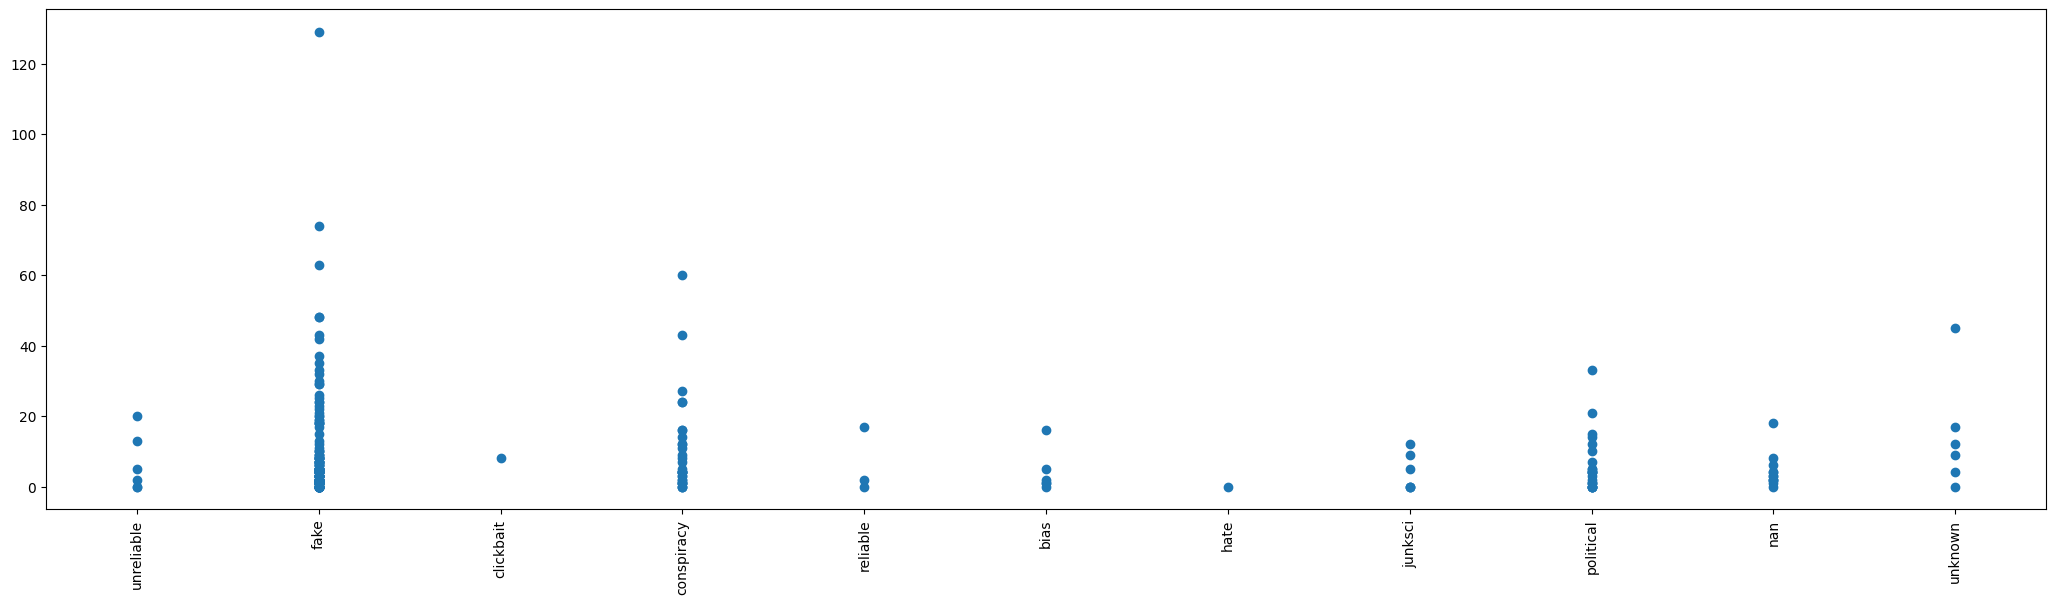

In [30]:
from functions import pair_keyword_type, scatterplot_keyword_type
scatterplot_keyword_type("num", data250)

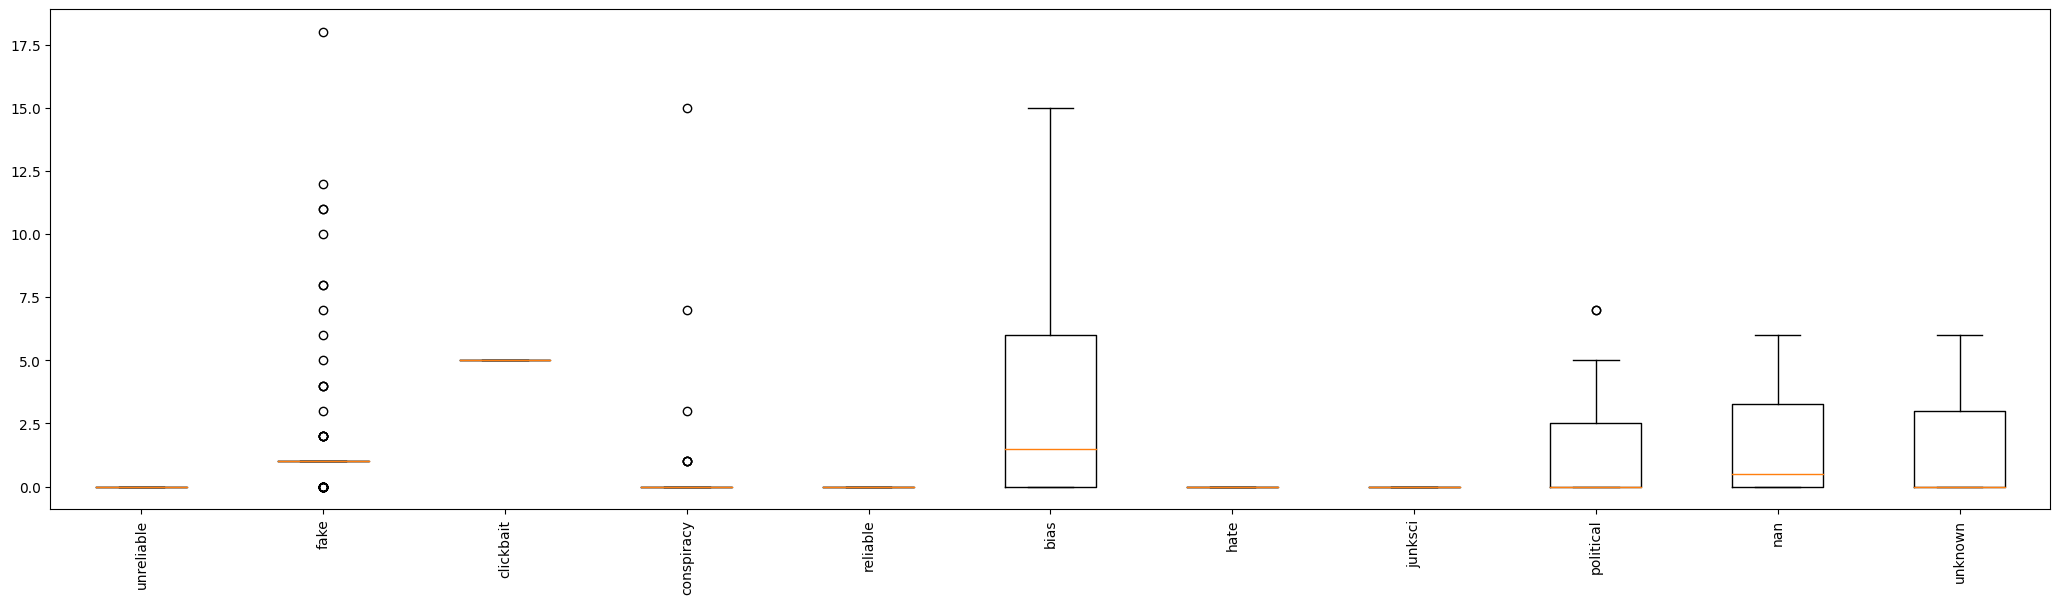

In [31]:
from functions import boxplot_keyword_type
boxplot_keyword_type('trump', data250)

[3.5, 3.0, 8.0, 4.0, 2.0, 1.5, 0.0, 2.5, 4.0, 3.0, 10.5]
[6.666666666666667, 8.987096774193548, 8.0, 10.387096774193548, 6.333333333333333, 4.166666666666667, 0.0, 4.333333333333333, 6.3478260869565215, 4.416666666666667, 14.5]
['unreliable', 'fake', 'clickbait', 'conspiracy', 'reliable', 'bias', 'hate', 'junksci', 'political', 'nan', 'unknown']


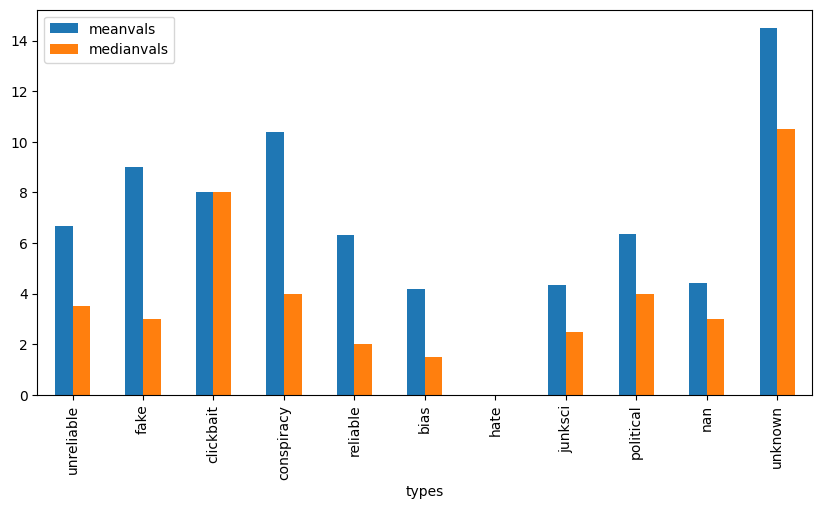

In [32]:
from functions import barplot_keyword_type
barplot_keyword_type('num', data250) 

### Get subset of full dataset

First we import the necessary libraries

In [33]:
import csv
import pandas as pd
import random
import pyarrow.feather as feather
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time

We define a function to load a subset of the articles

In [34]:
#Indhenter et sample på ca. 1,45M artikler, meget tidseffektivt
def getSample(csvstring: str, sample_size: int):
    random.seed(0)
    n = 11000000 #number of records in file (excludes header)
    s = sample_size #desired sample size
    skip = sorted(random.sample(range(1,n+1),n-s))
    # Read the CSV file, skipping the randomly selected rows
    sampled_data = pd.read_csv(csvstring, on_bad_lines='skip', skiprows=skip, index_col=0)
    sampled_data = sampled_data.reset_index()
    return sampled_data

In [35]:
data = getSample("data/news_cleaned_2018_02_13-1.csv", 1900000)

FileNotFoundError: [Errno 2] No such file or directory: 'data/news_cleaned_2018_02_13-1.csv'

In [ ]:
len(data)

### Inspecting The Sample

In [ ]:
def get_type_freq(dataframe):
    typedict = {}
    for i in dataframe['type']: 
        if str(i) in typedict:
            typedict[str(i)] +=1 
        else: 
            typedict[str(i)] =1 
    typedict
    typedictperc = typedict.copy()
    #laver et nyt dictionairy som viser det i procenttal
    for i in typedictperc:
        typedictperc[i] = (typedictperc[i]/(len(data)))*100
    return typedictperc

In [ ]:
get_type_freq(data)

{'conspiracy': 9.737514666261081,
 'unreliable': 3.516982987137146,
 'fake': 10.469945028680689,
 'satire': 1.3180623153137494,
 'reliable': 22.41799115678776,
 'hate': 0.8901605683990961,
 'clickbait': 2.732270119937424,
 'political': 19.452622544759258,
 'junksci': 1.3713633104467235,
 'bias': 13.362186033373892,
 'rumor': 5.605703002781158,
 'nan': 4.728579110898662,
 'unknown': 4.395804362941074,
 '2018-02-07 23:39:33.852696': 0.0002715974274291674,
 '2018-02-10 13:43:39.521661': 0.00040739614114375107,
 '2018-02-10 13:43:39.521686': 0.0001357987137145837}

In [ ]:
allArticlesCount = 928083 + 146080 + 1300444 + 905981 + 144939 + 117374 + 292201 + 2435471 + 319830 + 1920139
#Jeg henter data from README.md om hvor mange artikler af hver type, der er i det fulde datasæt
realtypeperc = {"reliable": (1920139/allArticlesCount)*100, "political": (2435471/allArticlesCount)*100, "bias": (1300444/allArticlesCount)*100, "Satire": (146080/allArticlesCount)*100, "fake": (928083/allArticlesCount)*100, "conspiracy":(905981/allArticlesCount)*100, "unreliable": (319830/allArticlesCount)*100, "clickbait":(292201/allArticlesCount)*100, "junksci":(144939/allArticlesCount)*100 , "hate":(117374/allArticlesCount)*100}
realtypeperc
#jeg præsenterer det som procenter
#ved sammenligning er det tydeligt, at Mikkels forkortede datasæt ikke har markant anderledes proportion ift. artikeltyper, end det fulde datasæt
#Største forskel er at der er tilføjet nye typer af artikler som rumor til datasættet, siden README blev skrevet. 
#Vi kan bruge dette til at forsikre os selv om at vores forkortede datasæt er repræsentativt for det fulde datasæt. 

{'reliable': 22.561888537768805,
 'political': 28.617108052577617,
 'bias': 15.280389897611691,
 'Satire': 1.716459421738357,
 'fake': 10.905098641191126,
 'conspiracy': 10.645397202669349,
 'unreliable': 3.7580450222794273,
 'clickbait': 3.4334005989277774,
 'junksci': 1.703052520039264,
 'hate': 1.3791601051965903}

### Structure Sample For Preprocessing

Before we preprocess there are some articles we can remove from the data set. We also change the labels so that
they are either 'reliable' or 'fake'

In [ ]:
def structure_dataframe(df): 
    # set all lables to either 'reliable' or 'fake' using the rules below
    df.type = df.type.replace({'political': 'reliable', 'junksci': 'fake', 'bias' : 'fake', 'satire': 'fake', 'conspiracy': 'fake', 'rumor': 'fake', 'unreliable' : 'fake', 'clickbait': 'fake', 'hate': 'fake'})
    # there are some junk labels due to bad formatting, so we remove those
    df = df[(df.type == 'reliable') |(df.type == 'fake')]
    # remove all NaN types
    df = df[df.type.notnull()]
    # remove all NaN content
    df = df[df.content.notnull()]
    # remove duplicates. Some entries have simmilar content, like a notification from Google Plus
    # or a message saying that the TOR browser needs to be installed in order view the article.
    df = df.drop_duplicates(subset = 'content', keep = 'last')
    
    df = df.reset_index()
    return df

In [ ]:
data = structure_dataframe(data)

In [ ]:
len(data)

1082496

In [ ]:
def labelperc(df): 
    labeldict = {}
    for i in df.type: 
        if i in labeldict: 
            labeldict[i] +=1
        else: 
            labeldict[i] = 1
    for i in labeldict: 
        labeldict[i] = labeldict[i]/len(df)*100
    return labeldict

In [ ]:
labelperc(data)

{'fake': 51.66993688660282, 'reliable': 48.33006311339719}

In [ ]:
data.to_csv("data/sample_structured.csv")

### Preprocessing the larger sample

Then, we preprocess the sample

In [43]:
from datetime import datetime
file_name = "data/sample_preprocessed_ver_" + datetime.today().strftime('%Y-%m-%d-%s')
for chunck in pd.read_csv("data/sample_structured.csv", chunksize=50000):
    clean_dataframe(chunck)
    preprocess(chunck)
    start = time.time()
    chunck.to_csv(file_name, mode='a')
    end = time.time()
    print("writing to csv took " + str(end - start) + " seconds")

cleaning took 106.79770350456238 seconds
tokenizing took 66.3427619934082 seconds
removing stopwords took 1.2303242683410645 seconds
stemming took 0.40837740898132324 seconds
converting to list took 281.87730526924133 seconds
writing to csv took 4.1791770458221436 seconds
cleaning took 108.93853974342346 seconds


KeyError: 0